In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style('whitegrid')


HOWELL1_DATA_LOCATION = '../../data/howell1.csv' 

In [2]:
df = pd.read_csv(HOWELL1_DATA_LOCATION)
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
df.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


# Plots

<AxesSubplot:xlabel='height', ylabel='Count'>

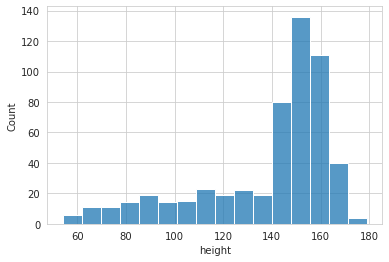

In [4]:
sns.histplot(df['height'])

<AxesSubplot:xlabel='weight', ylabel='Count'>

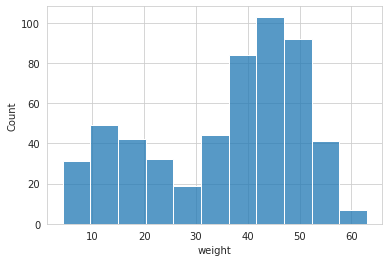

In [5]:
sns.histplot(df['weight'])

<AxesSubplot:xlabel='age', ylabel='Count'>

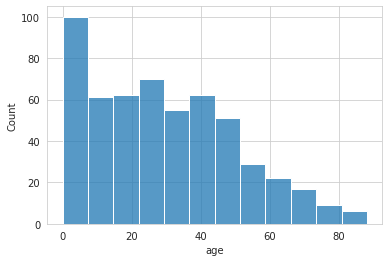

In [6]:
sns.histplot(df['age'])

### Only Adults

If we consider only the adults in the population, then the distributions are more normal-like.

In [7]:
df_adults = df[df['age'] >= 18]

df_adults.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


<AxesSubplot:xlabel='height', ylabel='Count'>

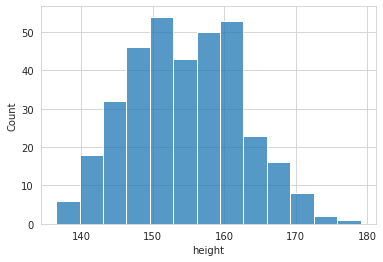

In [8]:
sns.histplot(df_adults['height'])

<AxesSubplot:xlabel='weight', ylabel='Count'>

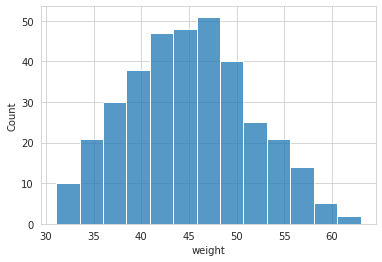

In [9]:
sns.histplot(df_adults['weight'])

## Modeling Heights as a Normally Distributed Variable

We assume that the heights in the population is a normally distributed variable $N(\mu, \sigma)$ with an unknown mean $\mu$ and unknown standard deviation $\sigma$.
$$
    h_i \overset{\text{iid}}{\sim} N(\mu, \sigma). 
$$

We specify individual priors for $\mu$ and $\sigma$ and assume that $\text{Pr}\{ \mu, \sigma \} = \text{Pr}\{ \mu \} \text{Pr}\{ \sigma \}$. 
$$
\begin{align*}
    \mu & \sim N(178, 20) \\
    \sigma & \sim \text{Uniform}(0, 50)
\end{align*}
$$

In order to estimate the most plausible values of $\mu$ and $\sigma$, we use Bayes' Theorem which in this context can be written as:
$$
\begin{align*}
    \text{Pr} \{ \mu, \sigma \vert h_1, \ldots, h_n \} 
        & = \frac{\prod_{i = 1}^n \text{Pr} \{h_i \vert \mu, \sigma \} \cdot \text{Pr} \{ \mu \} \cdot \text{Pr} \{ \sigma \}}{\int \int \prod_{i = 1}^n \text{Pr} \{h_i \vert \mu, \sigma \} \cdot \text{Pr} \{ \mu \} \cdot \text{Pr} \{ \sigma \} d \mu d \sigma},
\end{align*}
$$
where $\text{Pr} \{ \mu \} = N(\mu \vert 178, 20)$ and $\text{Pr} \{ \sigma \} = \text{Uniform} (\sigma \vert (0, 50))$.

### Plotting the Priors

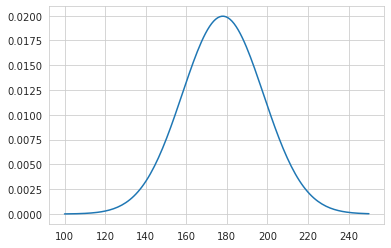

In [10]:
import numpy as np
from scipy.stats import norm


mu_grid = np.linspace(100, 250, num=150)
mu_vals = norm.pdf(mu_grid, loc=178, scale=20)
plt.plot(mu_grid, mu_vals)

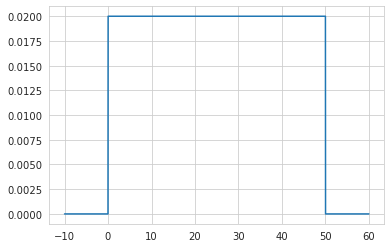

In [11]:
from scipy.stats import uniform


sigma_grid = np.linspace(-10, 60, num=7000)
sigma_vals = uniform.pdf(sigma_grid, loc=0, scale=50)
plt.plot(sigma_grid, sigma_vals)

### Prior Predictive Simulation

The choice of priors for $h$, $\mu$, and $\sigma$ imply a joint prior distribution of heights. To see how heights might be distributed, we sample from this joint distribution. Such a simulation is called a prior predictive simulation.

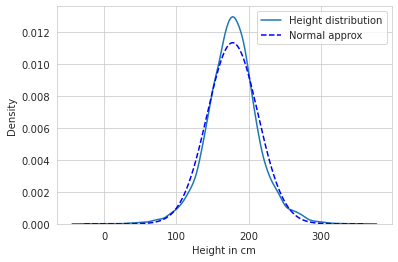

In [12]:
NUM_SAMPLES = 10000

mu_sample = norm.rvs(loc=178, scale=20, size=NUM_SAMPLES)
sd_sample = uniform.rvs(loc=0, scale=50, size=NUM_SAMPLES)

prior_heights = norm.rvs(loc=mu_sample, scale=sd_sample, size=NUM_SAMPLES)

mean_ht = np.mean(prior_heights)
sd_ht = np.std(prior_heights)
min_ht = np.min(prior_heights)
max_ht = np.max(prior_heights)

ht_grid = np.linspace(min_ht, max_ht, num=1000)
norm_vals = norm.pdf(ht_grid, loc=mean_ht, scale=sd_ht)

sns.kdeplot(prior_heights, label='Height distribution')
plt.plot(ht_grid, norm_vals, 'b--', label='Normal approx')

plt.xlabel('Height in cm')
plt.legend()
plt.show()

### Grid Approximation

In what follows, we compute the posterior by evaluating the terms in Bayes' equation. We use logarithms so that the products in the equation: 
\begin{align*}
    \text{Pr} \{ \mu, \sigma \vert h_1, \ldots, h_n \} 
        & = \frac{\prod_{i = 1}^n \text{Pr} \{h_i \vert \mu, \sigma \} \cdot \text{Pr} \{ \mu \} \cdot \text{Pr} \{ \sigma \}}{\int \int \prod_{i = 1}^n \text{Pr} \{h_i \vert \mu, \sigma \} \cdot \text{Pr} \{ \mu \} \cdot \text{Pr} \{ \sigma \} d \mu d \sigma},
\end{align*}
are converted to sums.

### Code 4.16

In [13]:
import itertools


NUM_SAMPLES = 100

mu_list = np.linspace(start=150, stop=160, num=NUM_SAMPLES)
sd_list = np.linspace(start=7, stop=9, num=NUM_SAMPLES)

# Create expanded lists of mu and sigma values s.t. zipping them yields all possible (mu, sigma) vals
mu_list_expanded = np.repeat(mu_list, NUM_SAMPLES) # np.repeat([1, 2, 3], 2) = [1, 1, 2, 2, 3, 3]
sd_list_expanded = np.tile(sd_list, NUM_SAMPLES) # np.tile([1, 2, 3], 2) = [1, 2, 3, 1, 2, 3]

likelihood = np.array([sum(norm.logpdf(df_adults['height'], loc=mu, scale=sd)) 
                       for mu, sd in zip(mu_list_expanded, sd_list_expanded)])

posterior_product = (likelihood + 
                     norm.logpdf(mu_list_expanded, loc=178, scale=20) + 
                     uniform.logpdf(sd_list_expanded, loc=0, scale=50))

post_prob = np.exp(posterior_product - max(posterior_product))

### Contour Plot

In order to plot the posterior probabilitites for $(\mu, \sigma)$ pairs, we use the original `mu_list` and `sd_list` arrays. The `post_prob` however has to be converted to an array of dimension `mu_list * sd_list`.

In [14]:
post_prob.shape

(10000,)

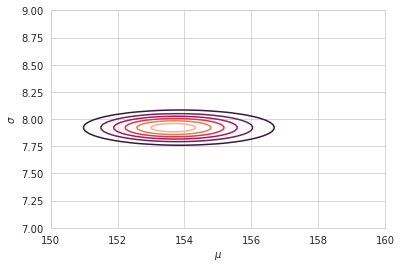

In [15]:
posterior_grid = np.reshape(post_prob, (NUM_SAMPLES, NUM_SAMPLES))

plt.contour(mu_list, sd_list, posterior_grid)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

### Sampling From the Posterior

We first sample the most likely $(\mu, \sigma)$ pairs using the posterior probabilities. We have 10,000 samples, with replacement, from the posterior for the height data. 

### Figure 4.4 in book.

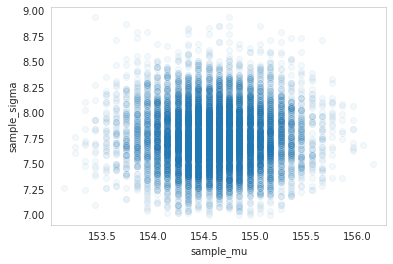

In [16]:
indices = range(0, len(mu_list_expanded))

sample_rows = np.random.choice(indices, 
                               size=10000, 
                               replace=True, 
                               p = post_prob / post_prob.sum())


sample_mu = mu_list_expanded[sample_rows]
sample_sd = sd_list_expanded[sample_rows]

plt.plot(sample_mu, sample_sd, 'o', alpha=0.05) # alpha \in [0, 1] controls the transparency
plt.axis('equal')
plt.grid(False)

plt.xlabel('sample_mu')
plt.ylabel('sample_sigma')

plt.show()

### Marginal Posterior Densities

Both marginals are normal-like. The posterior for $\sigma$ has a longer right-hand tail.

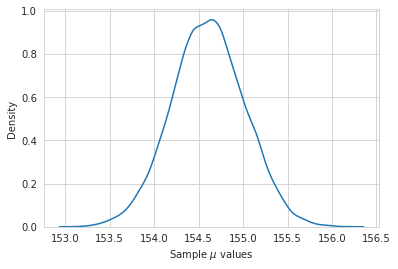

In [17]:
sns.kdeplot(sample_mu)
plt.xlabel(r'Sample $\mu$ values' )

plt.show()

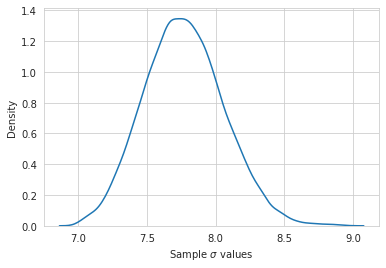

In [18]:
sns.kdeplot(sample_sd)
plt.xlabel(r'Sample $\sigma$ values' )

plt.show()

### Highest Posterior Densities

We do this using the Arviz library. From the docs: Calculate highest density interval (HDI) of array for given probability. The HDI is the minimum width Bayesian credible interval (BCI).

In [19]:
import arviz as az


az.hdi(sample_mu), az.hdi(sample_sd)

(array([153.73737374, 155.25252525]), array([7.22222222, 8.29292929]))

### Sample Size and the Normality of $\sigma$'s Posterior

### Code 4.23, 4.24, 4.25

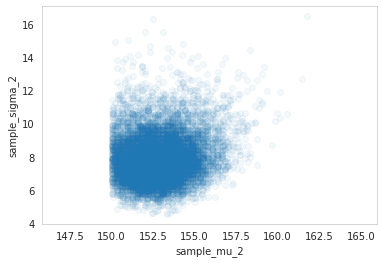

In [20]:
import itertools


NUM_SAMPLES = 200

ht_samples = np.random.choice(df_adults['height'], 20)

mu_list = np.linspace(start=150, stop=170, num=NUM_SAMPLES)
sd_list = np.linspace(start=4, stop=20, num=NUM_SAMPLES)

# Create expanded lists of mu and sigma values s.t. zipping them yields all possible (mu, sigma) vals
mu_list_expanded = np.repeat(mu_list, NUM_SAMPLES) # np.repeat([1, 2, 3], 3) = [1, 1, 1, 2, 2, 2, 3, 3, 3]
sd_list_expanded = np.tile(sd_list, NUM_SAMPLES) # np.tile([1, 2, 3], 3) =     [1, 2, 3, 1, 2, 3, 1, 2, 3]

likelihood_2 = np.array([sum(norm.logpdf(ht_samples, loc=mu, scale=sd)) 
                         for mu, sd in zip(mu_list_expanded, sd_list_expanded)])

posterior_product_2 = (likelihood_2 + 
                       norm.logpdf(mu_list_expanded, loc=178, scale=20) + 
                       uniform.logpdf(sd_list_expanded, loc=0, scale=50))

post_prob_2 = np.exp(posterior_product_2 - max(posterior_product_2))

indices = range(0, len(mu_list_expanded))

sample_rows = np.random.choice(indices, 
                               size=10000, 
                               replace=True, 
                               p = (post_prob_2 / post_prob_2.sum()))


sample_mu_2 = mu_list_expanded[sample_rows]
sample_sd_2 = sd_list_expanded[sample_rows]

plt.plot(sample_mu_2, sample_sd_2, 'o', alpha=0.05) # alpha \in [0, 1] controls the transparency
plt.axis('equal')
plt.grid(False)

plt.xlabel('sample_mu_2')
plt.ylabel('sample_sigma_2')

plt.show()

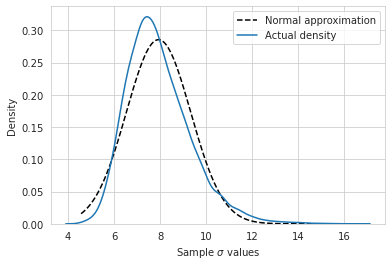

In [21]:
sd_2_mean = np.mean(sample_sd_2)
sd_2_sd = np.std(sample_sd_2)
sd_2_min = np.min(sample_sd_2) 
sd_2_max = np.max(sample_sd_2)

sd_2_grid = np.linspace(sd_2_min, sd_2_max, num=1000)
sd_2_norm_approx = norm.pdf(sd_2_grid, loc=sd_2_mean, scale=sd_2_sd)

plt.plot(sd_2_grid, sd_2_norm_approx, '--', color='black', label='Normal approximation')
sns.kdeplot(sample_sd_2, label='Actual density')
plt.xlabel(r'Sample $\sigma$ values' )

plt.legend()
plt.show()